# Abundance zeropoint analysis

## Author(s): Sven Buder (SB, WG4)

### History:
180926 SB Created

In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import os
import sys
import glob
import pickle
import pandas

# Packages to work with FITS and (IDL) SME.out files
import astropy.io.fits as pyfits
import astropy.table as table
from scipy.io.idl import readsav

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.transforms import Bbox,TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib._png import read_png
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

params = {
    'font.family'        : 'sans',
    'font.size'          : 17,
    'axes.labelsize'     : 20,
    'ytick.labelsize'    : 16,
    'xtick.labelsize'    : 16,
    'legend.fontsize'    : 20,
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

_parula_data = [[0.2081, 0.1663, 0.5292], 
                [0.2116238095, 0.1897809524, 0.5776761905], 
                [0.212252381, 0.2137714286, 0.6269714286], 
                [0.2081, 0.2386, 0.6770857143], 
                [0.1959047619, 0.2644571429, 0.7279], 
                [0.1707285714, 0.2919380952, 0.779247619], 
                [0.1252714286, 0.3242428571, 0.8302714286], 
                [0.0591333333, 0.3598333333, 0.8683333333], 
                [0.0116952381, 0.3875095238, 0.8819571429], 
                [0.0059571429, 0.4086142857, 0.8828428571], 
                [0.0165142857, 0.4266, 0.8786333333], 
                [0.032852381, 0.4430428571, 0.8719571429], 
                [0.0498142857, 0.4585714286, 0.8640571429], 
                [0.0629333333, 0.4736904762, 0.8554380952], 
                [0.0722666667, 0.4886666667, 0.8467], 
                [0.0779428571, 0.5039857143, 0.8383714286], 
                [0.079347619, 0.5200238095, 0.8311809524], 
                [0.0749428571, 0.5375428571, 0.8262714286], 
                [0.0640571429, 0.5569857143, 0.8239571429], 
                [0.0487714286, 0.5772238095, 0.8228285714], 
                [0.0343428571, 0.5965809524, 0.819852381], 
                [0.0265, 0.6137, 0.8135], 
                [0.0238904762, 0.6286619048, 0.8037619048], 
                [0.0230904762, 0.6417857143, 0.7912666667], 
                [0.0227714286, 0.6534857143, 0.7767571429], 
                [0.0266619048, 0.6641952381, 0.7607190476], 
                [0.0383714286, 0.6742714286, 0.743552381], 
                [0.0589714286, 0.6837571429, 0.7253857143], 
                [0.0843, 0.6928333333, 0.7061666667], 
                [0.1132952381, 0.7015, 0.6858571429], 
                [0.1452714286, 0.7097571429, 0.6646285714], 
                [0.1801333333, 0.7176571429, 0.6424333333], 
                [0.2178285714, 0.7250428571, 0.6192619048], 
                [0.2586428571, 0.7317142857, 0.5954285714], 
                [0.3021714286, 0.7376047619, 0.5711857143], 
                [0.3481666667, 0.7424333333, 0.5472666667], 
                [0.3952571429, 0.7459, 0.5244428571], 
                [0.4420095238, 0.7480809524, 0.5033142857], 
                [0.4871238095, 0.7490619048, 0.4839761905], 
                [0.5300285714, 0.7491142857, 0.4661142857], 
                [0.5708571429, 0.7485190476, 0.4493904762],
                [0.609852381, 0.7473142857, 0.4336857143], 
                [0.6473, 0.7456, 0.4188], 
                [0.6834190476, 0.7434761905, 0.4044333333], 
                [0.7184095238, 0.7411333333, 0.3904761905], 
                [0.7524857143, 0.7384, 0.3768142857], 
                [0.7858428571, 0.7355666667, 0.3632714286], 
                [0.8185047619, 0.7327333333, 0.3497904762], 
                [0.8506571429, 0.7299, 0.3360285714], 
                [0.8824333333, 0.7274333333, 0.3217], 
                [0.9139333333, 0.7257857143, 0.3062761905], 
                [0.9449571429, 0.7261142857, 0.2886428571], 
                [0.9738952381, 0.7313952381, 0.266647619], 
                [0.9937714286, 0.7454571429, 0.240347619], 
                [0.9990428571, 0.7653142857, 0.2164142857], 
                [0.9955333333, 0.7860571429, 0.196652381], 
                [0.988, 0.8066, 0.1793666667], 
                [0.9788571429, 0.8271428571, 0.1633142857], 
                [0.9697, 0.8481380952, 0.147452381], 
                [0.9625857143, 0.8705142857, 0.1309], 
                [0.9588714286, 0.8949, 0.1132428571], 
                [0.9598238095, 0.9218333333, 0.0948380952], 
                [0.9661, 0.9514428571, 0.0755333333], 
                [0.9763, 0.9831, 0.0538]]

parula = ListedColormap(_parula_data, name='parula')
parula_zero = _parula_data[0]
parula_0 = ListedColormap(_parula_data, name='parula_0')
parula_0.set_bad((1,1,1))
parula_r = ListedColormap(_parula_data[::-1], name='parula_r')

willi_blau = [0.0722666667, 0.4886666667, 0.8467]

# Sun (reference: Asplund et al. 2009)

In [2]:
sun = {}

sun['Teff'] = [5772., 0.00] # Prsa et al., 2016, AJ, 152, 41
sun['logg'] = [4.44, 0.00] # Prsa et al., 2016, AJ, 152, 41
sun['mass'] = [1.00 , 0.00] # by definition
sun['lbol'] = [1.00 , 0.00] # by definition
sun['age']  = [4.57 , 0.11] # Bonanno et al., 2002, A&A, 390, 1115

# Z, A_X, e_A_X
sun["A_Li"] = [1.05, 0.10,  3]
sun["A_C"]  = [8.43, 0.05,  6]
sun["A_O"]  = [8.69, 0.05,  8]
sun["A_Na"] = [6.24, 0.04, 11]
sun["A_Mg"] = [7.60, 0.04, 12]
sun["A_Al"] = [6.45, 0.03, 13]
sun["A_Si"] = [7.51, 0.03, 14]
sun["A_K"]  = [5.03, 0.09, 19]
sun["A_Ca"] = [6.34, 0.04, 20]
sun["A_Sc"] = [3.15, 0.04, 21]
sun["A_Ti"] = [4.95, 0.05, 22]
sun["A_V"]  = [3.93, 0.08, 23]
sun["A_Cr"] = [5.64, 0.04, 24]
sun["A_Mn"] = [5.43, 0.04, 25]
sun["A_Fe"] = [7.50, 0.04, 26]
sun["A_Co"] = [4.99, 0.07, 27]
sun["A_Ni"] = [6.22, 0.04, 28]
sun["A_Cu"] = [4.19, 0.04, 29]
sun["A_Zn"] = [4.56, 0.05, 30]
sun["A_Rb"] = [2.52, 0.10, 37]
sun["A_Sr"] = [2.87, 0.07, 38]
sun["A_Y"]  = [2.21, 0.05, 39]
sun["A_Zr"] = [2.58, 0.04, 40]
sun["A_Mo"] = [1.88, 0.08, 42]
sun["A_Ru"] = [1.75, 0.08, 44]
sun["A_Ba"] = [2.18, 0.09, 56]
sun["A_La"] = [1.10, 0.04, 57]
sun["A_Ce"] = [1.58, 0.04, 58]
sun["A_Nd"] = [1.42, 0.04, 60]
sun["A_Sm"] = [0.96, 0.04, 62]
sun["A_Eu"] = [0.52, 0.04, 63]

# Arcturus (reference: internal APOGEE values, Ramirez & Allende Prieto 2011)

In [3]:
arcturus = {}

arcturus['Teff'] = [4286, 35] # Heiter et al., 2005, A&A, 582, 49
arcturus['logg'] = [1.60, 0.20] # Heiter et al., 2005, A&A, 582, 49
arcturus['fe_h'] = [-0.52, 0.08] # Heiter et al., 2005, A&A, 582, 49
arcturus['mass'] = [1.08 , 0.06] # Ramirez & Allende Prieto, 2011, ApJ, 743, 135
arcturus['lbol'] = [197.2, 2.2] # Heiter et al., 2005, A&A, 582, 49
arcturus['age']  = [7.1, 1.5] # Ramirez & Allende Prieto, 2011, ApJ, 743, 135

# Values from internal APOGEE communication, errors assumed to be 0.03!

arcturus["A_Li"] = [0.53, 0.03,  3]
arcturus["A_C"]  = [8.03, 0.03,  6]
arcturus["A_O"]  = [8.63, 0.03,  8]
arcturus["A_Na"] = [5.76, 0.03, 11]
arcturus["A_Mg"] = [7.38, 0.03, 12]
arcturus["A_Al"] = [6.19, 0.03, 13]
arcturus["A_Si"] = [7.32, 0.03, 14]
arcturus["A_K"]  = [4.76, 0.03, 19]
arcturus["A_Ca"] = [5.90, 0.03, 20]
arcturus["A_Sc"] = [2.80, 0.03, 21]
arcturus["A_Ti"] = [4.65, 0.03, 22]
arcturus["A_V"]  = [3.54, 0.03, 23]
arcturus["A_Cr"] = [5.07, 0.03, 24]
arcturus["A_Mn"] = [4.66, 0.03, 25]
arcturus["A_Fe"] = [6.93, 0.03, 26]
arcturus["A_Co"] = [4.49, 0.03, 27]
arcturus["A_Ni"] = [5.77, 0.03, 28]
arcturus["A_Cu"] = [3.71, 0.03, 29]
arcturus["A_Zn"] = [4.08, 0.03, 30]
arcturus["A_Rb"] = [2.08, 0.03, 37]
arcturus["A_Sr"] = [2.40, 0.03, 38]
arcturus["A_Y"]  = [1.69, 0.03, 39]
arcturus["A_Zr"] = [2.06, 0.03, 40]
arcturus["A_Mo"] = [1.40, 0.03, 42]
arcturus["A_Ru"] = [1.32, 0.03, 44]
arcturus["A_Ba"] = [1.65, 0.03, 56]
arcturus["A_La"] = [0.61, 0.03, 57]
arcturus["A_Ce"] = [0.99, 0.03, 58]
arcturus["A_Nd"] = [0.94, 0.03, 60]
arcturus["A_Sm"] = [0.48, 0.03, 62]
arcturus["A_Eu"] = [0.00, 0.03, 63]

# GALAH values

In [4]:
gbs_lbol     = pyfits.getdata('../gbs/data/GALAH_gbs_lbol.fits',1)
gbs_sun      = gbs_lbol[(gbs_lbol['sobject_id'] == 150405000901378)][0]
gbs_arcturus = gbs_lbol[(gbs_lbol['sobject_id'] == 150210005801171)][0]

In [5]:
galah_sun = {}

galah_sun['Teff'] = ['%.0f' % gbs_sun['TEFF'], '%.0f' % gbs_sun['E_TEFF']] 
galah_sun['logg'] = ['%.2f' % gbs_sun['LOGG'], np.nan] 
galah_sun['mass'] = ['%.2f' % gbs_sun['MASS'], np.nan] 
galah_sun['lbol'] = ['%.2f' % gbs_sun['LBOL'], np.nan] 
galah_sun['age']  = ['%.2f' % gbs_sun['AGE'], np.nan] 

# Z, A_X, e_A_X

for iterator, each_mode in enumerate(gbs_sun['MODE']):
    if (each_mode != 'Sp')  & (len(each_mode) <= 2) & (len(each_mode) >=1):
        galah_sun["A_"+each_mode] = [
            '%.2f' % gbs_sun['A_ABUND'][iterator], 
            '%.2f' % gbs_sun['E_ABUND'][iterator]
        ]
    else:
        if each_mode == 'K7699':
            galah_sun["A_K"] = [
                '%.2f' % gbs_sun['A_ABUND'][iterator],
                '%.2f' % gbs_sun['E_ABUND'][iterator]
            ]
        
        if each_mode == 'Ca5862':
            galah_sun["A_Ca"] = [
                '%.2f' % gbs_sun['A_ABUND'][iterator],
                '%.2f' % gbs_sun['E_ABUND'][iterator]
            ]

        if each_mode == 'Cu5782':
            galah_sun["A_Cu"] = [
                '%.2f' % gbs_sun['A_ABUND'][iterator],
                '%.2f' % gbs_sun['E_ABUND'][iterator]
            ]
            
        if each_mode == 'Ba5854':
            galah_sun["A_Ba"] = [
                '%.2f' % np.nanmean([gbs_sun['A_ABUND'][iterator],gbs_sun['A_ABUND'][iterator+1]]), 
                '%.2f' % np.nanmean([gbs_sun['E_ABUND'][iterator],gbs_sun['E_ABUND'][iterator+1]])
            ]

In [6]:
galah_arcturus = {}

galah_arcturus['Teff'] = ['%.0f' % gbs_arcturus['TEFF'], '%.0f' % gbs_arcturus['E_TEFF']] 
galah_arcturus['logg'] = ['%.2f' % gbs_arcturus['LOGG'], np.nan] 
galah_arcturus['mass'] = ['%.2f' % gbs_arcturus['MASS'], np.nan] 
galah_arcturus['lbol'] = ['%.2f' % gbs_arcturus['LBOL'], np.nan] 
galah_arcturus['age']  = ['%.2f' % gbs_arcturus['AGE'], np.nan] 

# Z, A_X, e_A_X

for iterator, each_mode in enumerate(gbs_arcturus['MODE']):
    if (each_mode != 'Sp')  & (len(each_mode) <= 2) & (len(each_mode) >=1):
        galah_arcturus["A_"+each_mode] = ['%.2f' % gbs_arcturus['A_ABUND'][iterator], '%.2f' % gbs_arcturus['E_ABUND'][iterator]]
    else:
        if each_mode == 'K7699':
            galah_arcturus["A_K"] = ['%.2f' % gbs_arcturus['A_ABUND'][iterator], '%.2f' % gbs_arcturus['E_ABUND'][iterator]]
        
        if each_mode == 'Ca5862':
            galah_arcturus["A_Ca"] = ['%.2f' % gbs_arcturus['A_ABUND'][iterator], '%.2f' % gbs_arcturus['E_ABUND'][iterator]]

        if each_mode == 'Cu5782':
            galah_arcturus["A_Cu"] = ['%.2f' % gbs_arcturus['A_ABUND'][iterator], '%.2f' % gbs_arcturus['E_ABUND'][iterator]]
            
        if each_mode == 'Ba5854':
            galah_arcturus["A_Ba"] = [
                '%.0f' % np.nanmean([gbs_arcturus['A_ABUND'][iterator],gbs_arcturus['A_ABUND'][iterator+1]]), 
                '%.0f' % np.nanmean([gbs_arcturus['E_ABUND'][iterator],gbs_arcturus['E_ABUND'][iterator+1]])
            ]

/Users/buder/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [7]:
for each_key in ['Teff','logg','A_Fe','mass','lbol','age']:
    print(each_key,',',sun[each_key][0],'$\pm$',sun[each_key][1],',',galah_sun[each_key][0],'$\pm$',galah_sun[each_key][1])

Teff , 5772.0 $\pm$ 0.0 , 5779 $\pm$ 104
logg , 4.44 $\pm$ 0.0 , 4.42 $\pm$ nan
A_Fe , 7.5 $\pm$ 0.04 , 7.38 $\pm$ 0.08
mass , 1.0 $\pm$ 0.0 , 0.97 $\pm$ nan
lbol , 1.0 $\pm$ 0.0 , 1.01 $\pm$ nan
age , 4.57 $\pm$ 0.11 , 5.83 $\pm$ nan


In [8]:
for each_key in sun.keys():
    if each_key not in ['Teff','logg','A_Fe','mass','lbol','age','fe_h']:
        print(each_key,',',sun[each_key][0],'$\pm$',sun[each_key][1],',',galah_sun[each_key][0],'$\pm$',galah_sun[each_key][1])

A_Zn , 4.56 $\pm$ 0.05 , 4.45 $\pm$ 0.05
A_Zr , 2.58 $\pm$ 0.04 , 2.14 $\pm$ 0.53
A_Ca , 6.34 $\pm$ 0.04 , 6.26 $\pm$ 0.07
A_Mn , 5.43 $\pm$ 0.04 , 5.39 $\pm$ 0.00
A_Ru , 1.75 $\pm$ 0.08 , nan $\pm$ nan
A_Ce , 1.58 $\pm$ 0.04 , 2.10 $\pm$ 0.02
A_Mg , 7.6 $\pm$ 0.04 , 7.56 $\pm$ 0.03
A_Mo , 1.88 $\pm$ 0.08 , nan $\pm$ nan
A_Ti , 4.95 $\pm$ 0.05 , 4.87 $\pm$ 0.08
A_Co , 4.99 $\pm$ 0.07 , nan $\pm$ nan
A_Cr , 5.64 $\pm$ 0.04 , 5.64 $\pm$ 0.09
A_Cu , 4.19 $\pm$ 0.04 , 4.08 $\pm$ 0.01
A_Rb , 2.52 $\pm$ 0.1 , nan $\pm$ nan
A_V , 3.93 $\pm$ 0.08 , 3.95 $\pm$ 0.01
A_Eu , 0.52 $\pm$ 0.04 , nan $\pm$ nan
A_Y , 2.21 $\pm$ 0.05 , 1.88 $\pm$ 0.08
A_Sr , 2.87 $\pm$ 0.07 , nan $\pm$ nan
A_C , 8.43 $\pm$ 0.05 , 8.42 $\pm$ 0.02
A_Al , 6.45 $\pm$ 0.03 , 6.42 $\pm$ 0.08
A_O , 8.69 $\pm$ 0.05 , 8.65 $\pm$ 0.04
A_K , 5.03 $\pm$ 0.09 , 5.41 $\pm$ 0.00
A_Ni , 6.22 $\pm$ 0.04 , 6.27 $\pm$ 0.05
A_Li , 1.05 $\pm$ 0.1 , 0.95 $\pm$ 0.38
A_Ba , 2.18 $\pm$ 0.09 , 2.15 $\pm$ 0.01
A_Na , 6.24 $\pm$ 0.04 , 6.11 $\pm$ 

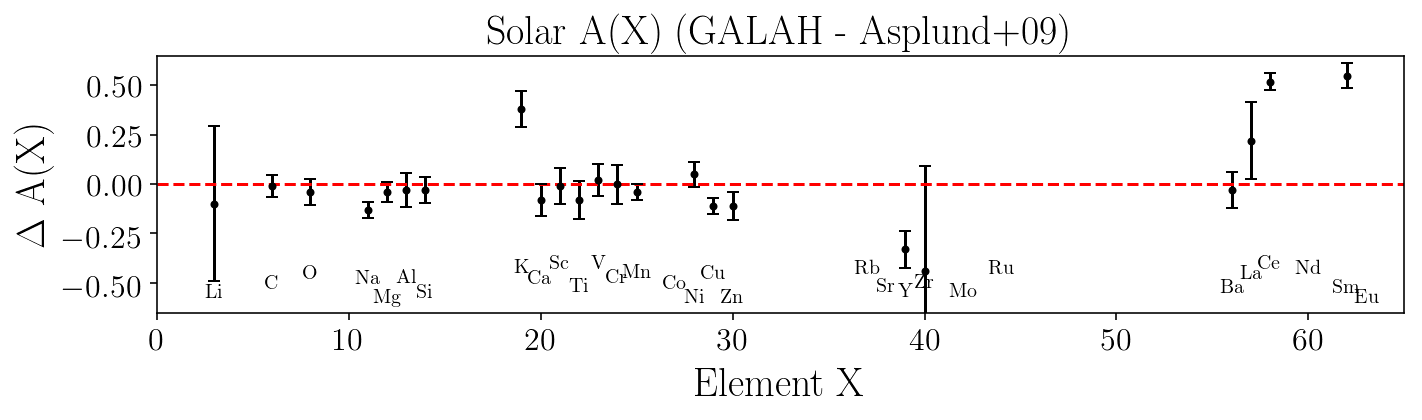

In [9]:
kwargs_errorbar = dict(color = 'k', capsize=3, fmt='o', ms=3)

f, (ax1) = plt.subplots(1, figsize=(10,3))

ax1.set_title('Solar A(X) (GALAH - Asplund+09)', fontsize=20)
ax1.axhline(0, color='r', ls='dashed')
ax1.set_ylim(-0.651, 0.651)
ax1.set_xlim(0,65)
ax1.set_xlabel('Element X')
ax1.set_ylabel(r'$\Delta$ A(X)')
ax1.set_yticks([-0.5, -0.25, 0.0, 0.25, 0.5])

for it, each_key in enumerate(sun.keys()):
    if each_key not in ['Teff','logg','A_Fe','mass','lbol','age','fe_h']:
        ax1.errorbar(
            sun[each_key][2],
            float(galah_sun[each_key][0]) - float(sun[each_key][0]),
            yerr = np.sqrt(float(galah_sun[each_key][1])**2 + float(sun[each_key][1])**2),
            **kwargs_errorbar
            )
        ax1.text(sun[each_key][2], -.6 + it%8*0.025, each_key[2:],ha='center')
plt.tight_layout()
plt.savefig('figures/abundance_zeropoints_sun.png', dpi=300, bbox_inches='tight')

In [10]:
for each_key in ['Teff','logg','A_Fe','mass','lbol','age']:
    print(each_key,',',arcturus[each_key][0],'$\pm$',arcturus[each_key][1],',',galah_arcturus[each_key][0],'$\pm$',galah_arcturus[each_key][1])

Teff , 4286 $\pm$ 35 , 4289 $\pm$ 21
logg , 1.6 $\pm$ 0.2 , 1.65 $\pm$ nan
A_Fe , 6.93 $\pm$ 0.03 , 6.83 $\pm$ 0.03
mass , 1.08 $\pm$ 0.06 , 0.96 $\pm$ nan
lbol , 197.2 $\pm$ 2.2 , 179.87 $\pm$ nan
age , 7.1 $\pm$ 1.5 , 9.42 $\pm$ nan


In [11]:
for each_key in arcturus.keys():
    if each_key not in ['Teff','logg','A_Fe','mass','lbol','age','fe_h']:
        print(each_key,',',arcturus[each_key][0],'$\pm$',arcturus[each_key][1],',',galah_arcturus[each_key][0],'$\pm$',galah_arcturus[each_key][1])

A_Zn , 4.08 $\pm$ 0.03 , 4.05 $\pm$ 0.00
A_Zr , 2.06 $\pm$ 0.03 , nan $\pm$ nan
A_Ca , 5.9 $\pm$ 0.03 , 5.88 $\pm$ 0.00
A_Mn , 4.66 $\pm$ 0.03 , 4.65 $\pm$ 0.00
A_Ru , 1.32 $\pm$ 0.03 , nan $\pm$ nan
A_Ce , 0.99 $\pm$ 0.03 , nan $\pm$ nan
A_Mg , 7.38 $\pm$ 0.03 , 7.44 $\pm$ 0.00
A_Mo , 1.4 $\pm$ 0.03 , nan $\pm$ nan
A_Ti , 4.65 $\pm$ 0.03 , 4.63 $\pm$ 0.03
A_Co , 4.49 $\pm$ 0.03 , 4.55 $\pm$ 0.00
A_Cr , 5.07 $\pm$ 0.03 , 5.02 $\pm$ 0.03
A_Cu , 3.71 $\pm$ 0.03 , 3.71 $\pm$ 0.00
A_Rb , 2.08 $\pm$ 0.03 , nan $\pm$ nan
A_V , 3.54 $\pm$ 0.03 , 3.68 $\pm$ 0.00
A_Eu , 0.0 $\pm$ 0.03 , nan $\pm$ nan
A_Y , 1.69 $\pm$ 0.03 , nan $\pm$ nan
A_Sr , 2.4 $\pm$ 0.03 , nan $\pm$ nan
A_C , 8.03 $\pm$ 0.03 , nan $\pm$ nan
A_Al , 6.19 $\pm$ 0.03 , 6.27 $\pm$ 0.00
A_O , 8.63 $\pm$ 0.03 , 8.78 $\pm$ 0.07
A_K , 4.76 $\pm$ 0.03 , 5.04 $\pm$ 0.00
A_Li , 0.53 $\pm$ 0.03 , -1.13 $\pm$ 0.45
A_Ni , 5.77 $\pm$ 0.03 , 5.86 $\pm$ 0.00
A_Ba , 1.65 $\pm$ 0.03 , nan $\pm$ nan
A_Na , 5.76 $\pm$ 0.03 , 5.84 $\pm$ 0.00
A_L

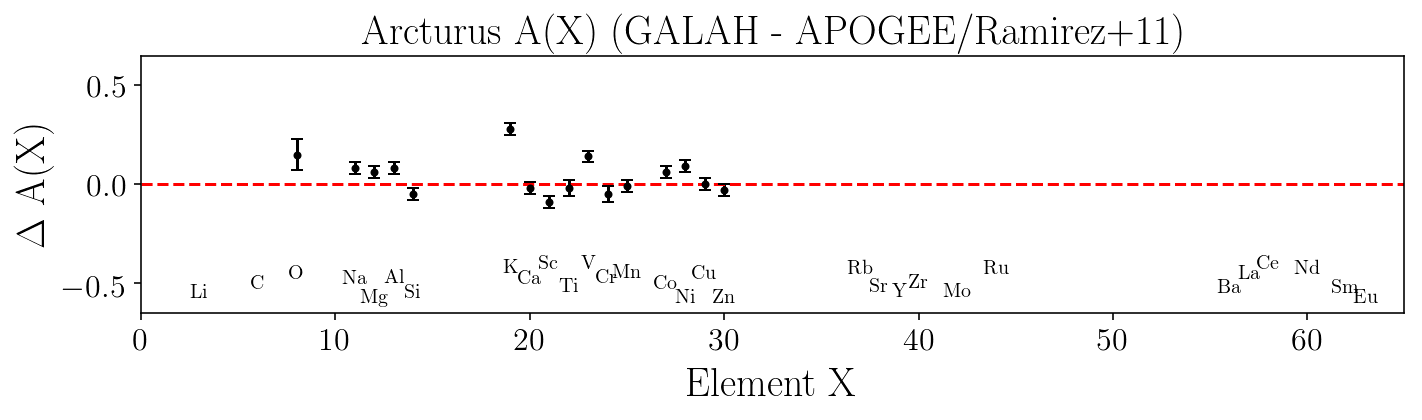

In [12]:
kwargs_errorbar = dict(color = 'k', capsize=3, fmt='o', ms=3)

f, (ax1) = plt.subplots(1, figsize=(10,3))
ax1.set_title('Arcturus A(X) (GALAH - APOGEE/Ramirez+11)', fontsize=20)

ax1.axhline(0, color='r', ls='dashed')
ax1.set_ylim(-0.651, 0.651)
ax1.set_xlim(0,65)
ax1.set_xlabel('Element X')
ax1.set_ylabel(r'$\Delta$ A(X)')

for it, each_key in enumerate(sun.keys()):
    if each_key not in ['Teff','logg','A_Fe','mass','lbol','age','fe_h']:
        ax1.errorbar(
            sun[each_key][2],
            float(galah_arcturus[each_key][0]) - float(arcturus[each_key][0]),
            yerr = np.sqrt(float(galah_arcturus[each_key][1])**2 + float(arcturus[each_key][1])**2),
            **kwargs_errorbar
            )
        ax1.text(arcturus[each_key][2], -.6 + it%8*0.025, each_key[2:],ha='center')

plt.tight_layout()
plt.savefig('figures/abundance_zeropoints_arcturus.png', dpi=300, bbox_inches='tight')